# Phishing URL Dataset Analysis

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve
)
import joblib

### Load the precomputed dataset

In [4]:
ls

Analysis.ipynb             package.json
SimpleExtension/           phishing_analysis 2.ipynb
data_analysis/             phishing_analysis.ipynb
datasets/                  phishing_urls.csv
node_modules/              rf_model.json
package-lock.json          trainer.py


In [6]:
df = pd.read_csv("datasets/features.csv")
X = df.drop(["label","url"], axis=1)
y = df["label"]

In [7]:
df

,url,url_length,dot_count,has_at,special_char_count,entropy,suspicious_keywords,subdomain_length,is_free_hosting,has_hyphen,...,fetchCount,xhrCount,wsCount,scriptInjectionCount,eventListenerCount,domMutationCount,attributeMutationCount,pageLoadTime,memoryUsed,label
0,https://kalmatron.su,20,1,0,0,3.418296,0,0,0,0,...,0,0,0,0,0,0,0,6174,10000000,0
1,https://mauviisephotoo.weebly.com/,34,2,0,0,3.893661,0,14,1,0,...,0,0,0,0,0,2,4,6524,12700000,1
2,https://ekontrol.pl,19,1,0,0,3.095795,0,0,0,0,...,0,0,0,0,0,3,243,7167,27600000,0
3,https://mariab.pk,17,1,0,0,2.947703,0,0,0,0,...,0,0,0,0,0,25,379,8448,26000000,0
4,https://dancearoundthekitchen.com,33,1,0,0,3.673270,0,0,0,0,...,0,0,0,0,0,5,0,11238,50400000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,https://qrco.de/bfJLu6,22,1,0,0,2.807355,0,0,0,0,...,0,0,0,0,0,0,0,6248,10000000,1
8287,https://noticeable.io,21,1,0,0,3.238901,0,0,0,0,...,0,0,0,0,0,0,0,8241,10000000,0
8288,https://gehu.ac.in,18,2,0,0,3.121928,0,4,0,0,...,0,0,0,0,0,0,0,6700,14300000,0
8289,https://astivahealth.com,24,1,0,0,3.452820,0,0,0,0,...,0,0,0,0,0,0,8,8014,10000000,0


### 1. Optimize n_estimators via OOB error

In [8]:
tree_range = list(range(10, 301, 10))
oob_errors = []
for n in tree_range:
    rf = RandomForestClassifier(n_estimators=n, oob_score=True, n_jobs=-1, random_state=42)
    rf.fit(X, y)
    oob_errors.append(1 - rf.oob_score_)

/opt/anaconda3/envs/TaskLighthouseENV/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/envs/TaskLighthouseENV/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [9]:
# verify labels
print(y.value_counts())


label
0    4844
1    3447
Name: count, dtype: int64


draw the data

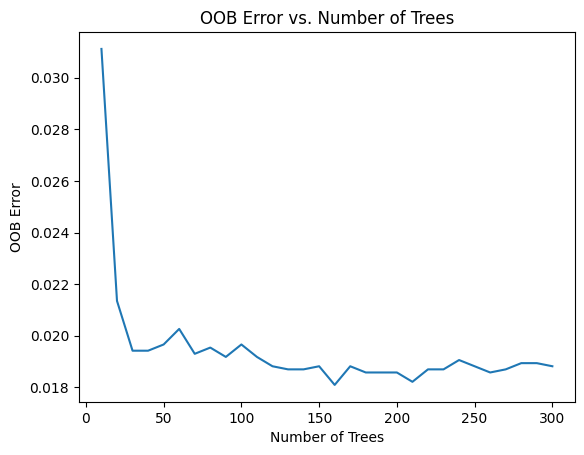

In [12]:
# Early stopping logic: find smallest n within ε of min error
min_error = min(oob_errors)
tolerance = 0.001  # Acceptable difference
best_n = next(n for i, n in enumerate(tree_range) if oob_errors[i] <= min_error + tolerance)

plt.figure()
plt.plot(tree_range, oob_errors)
plt.title("OOB Error vs. Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.show()

In [13]:
best_n

120

### 2. Feature importances

In [14]:
rf_sel = RandomForestClassifier(n_estimators=best_n, n_jobs=-1, random_state=42)
rf_sel.fit(X, y)
importances = rf_sel.feature_importances_
indices = np.argsort(importances)[::-1]


draw the data

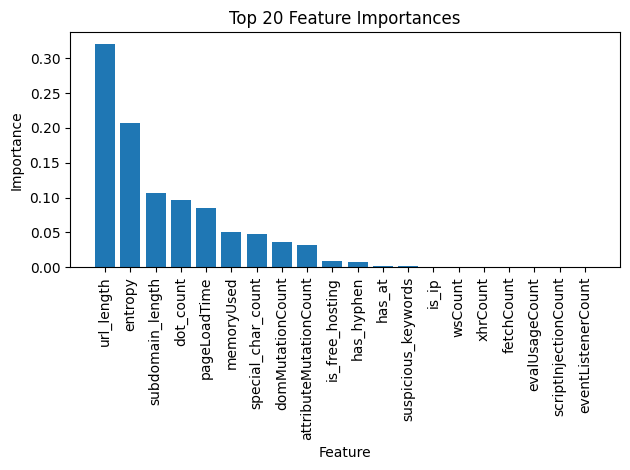

In [15]:
top_n = 20
plt.figure()
plt.bar(range(top_n), importances[indices][:top_n])
plt.xticks(range(top_n), [X.columns[i] for i in indices[:top_n]], rotation=90)
plt.title("Top 20 Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### 3. MAE vs number of selected features

In [16]:
mae_scores = []
ks = list(range(1, len(X.columns) + 1))
for k in ks:
    sel = [X.columns[i] for i in indices[:k]]
    scores = -cross_val_score(
        RandomForestClassifier(n_estimators=best_n, random_state=42),
        X[sel], y,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )
    mae_scores.append(scores.mean())

draw the data

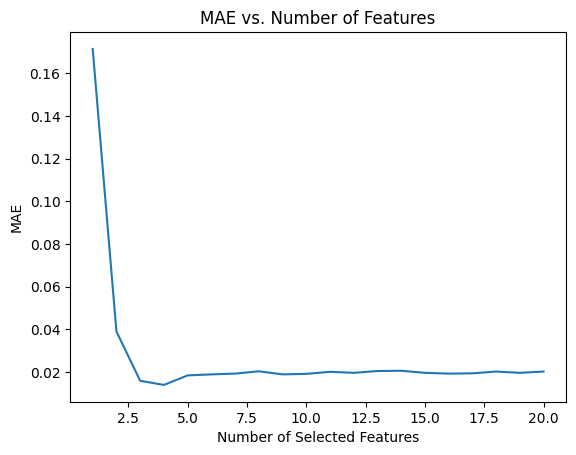

In [17]:
plt.figure()
plt.plot(ks, mae_scores)
plt.title("MAE vs. Number of Features")
plt.xlabel("Number of Selected Features")
plt.ylabel("MAE")
plt.show()

In [18]:
best_k = ks[np.argmin(mae_scores)]
selected_features = [X.columns[i] for i in indices[:best_k]]
X_sel = X[selected_features]

In [29]:
best_k

4

In [19]:
print("selected_features: ", selected_features)

selected_features:  ['url_length', 'entropy', 'subdomain_length', 'dot_count']


### 4. ROC curve and threshold selection

In [20]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
all_val_probs = []
all_val_labels = []

In [21]:
for train_idx, val_idx in skf.split(X_sel, y):
    m = RandomForestClassifier(n_estimators=best_n, random_state=42)
    m.fit(X_sel.iloc[train_idx], y.iloc[train_idx])
    probs = m.predict_proba(X_sel.iloc[val_idx])[:, 1]
    all_val_probs.extend(probs)
    all_val_labels.extend(y.iloc[val_idx])

In [22]:
all_val_probs = np.array(all_val_probs)
all_val_labels = np.array(all_val_labels)

In [23]:
fpr_arr, tpr_arr, thr_arr = roc_curve(all_val_labels, all_val_probs)
j_scores = tpr_arr - fpr_arr
best_idx = np.argmax(j_scores)
best_threshold = thr_arr[best_idx]

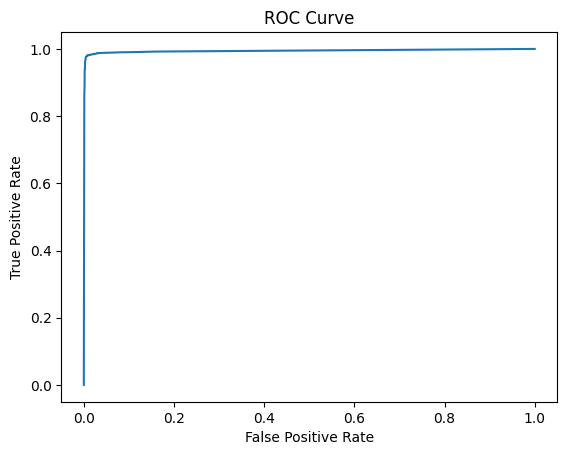

In [24]:
plt.figure()
plt.plot(fpr_arr, tpr_arr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [25]:
print("Optimal threshold: ", best_threshold)

Optimal threshold:  0.5833333333333334


### 5. Final train/test evaluation

In [26]:
from sklearn.model_selection import StratifiedKFold

print("🔄 Evaluating model using 10-fold cross-validation...")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precisions = []
recalls = []
f1s = []
fprs = []
tprs = []

for train_idx, test_idx in skf.split(X_sel, y):
    X_train, X_test = X_sel.iloc[train_idx], X_sel.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestClassifier(n_estimators=best_n, random_state=42)
    model.fit(X_train, y_train)

    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= best_threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    tp, fn, fp, tn = cm[1,1], cm[1,0], cm[0,1], cm[0,0]

    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    tprs.append(tp / (tp + fn))
    fprs.append(fp / (fp + tn))

# Print mean scores
print("\n📊 Cross-Validation Performance (averaged over folds):")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall (TPR): {np.mean(tprs):.4f}")
print(f"False Positive Rate (FPR): {np.mean(fprs):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")

🔄 Evaluating model using 10-fold cross-validation...

📊 Cross-Validation Performance (averaged over folds):
Precision: 0.9880
Recall (TPR): 0.9788
False Positive Rate (FPR): 0.0085
F1 Score: 0.9834


Export the model to the extension!!

In [27]:
import json
from sklearn.tree import export_text, export_graphviz
from sklearn.tree import _tree

final_model = RandomForestClassifier(n_estimators=best_n, random_state=42)
final_model.fit(X_sel, y)

def tree_to_dict(tree, feature_names):
    tree_ = tree.tree_

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            return {
                "feature": name,
                "threshold": threshold,
                "left": recurse(tree_.children_left[node]),
                "right": recurse(tree_.children_right[node])
            }
        else:
            return {"value": tree_.value[node].tolist()}

    return recurse(0)

# Pass the real feature names from your selected training columns
rf_json = [tree_to_dict(estimator, selected_features) for estimator in final_model.estimators_]

# Export to JSON
with open("./SimpleExtension/rf_model.json", "w") as f:
    json.dump(rf_json, f)


export to onnx

In [56]:
best_n = 30

In [57]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import joblib

# Pick only your four extractor features
rf = RandomForestClassifier(n_estimators=best_n, random_state=42)
rf.fit(X_sel, y)

# # Determine how many columns you used
# n_features = X_train.shape[1]     # must match your CSV’s feature columns

initial_type = [("float_input", FloatTensorType([None, 4]))]
onnx_model = convert_sklearn(rf, initial_types=initial_type)

with open("rf_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


In [58]:
input_tensor = onnx_model.graph.input[0]
dims = [d.dim_value for d in input_tensor.type.tensor_type.shape.dim]
print("ONNX input shape:", dims)

ONNX input shape: [0, 4]


In [59]:
import onnxruntime as ort
import numpy as np

sess = ort.InferenceSession("rf_model.onnx")
input_name  = sess.get_inputs()[0].name
output_names = [o.name for o in sess.get_outputs()]

# Build a dummy feature vector [url_length, dot_count, subdomain_length, entropy]
# Replace these values with real ones from your test CSV or manual example
X_sample = np.array([[100, 3, 10, 2.5]], dtype=np.float32)  # shape (1,4)

# Run inference
results = sess.run(output_names, {input_name: X_sample})
print("Raw ONNX outputs:", results)

# Depending on how skl2onnx encoded it, 
# you’ll typically get something like [label_array, probability_array]:
label_out, proba_out = results
print("Predicted label:", label_out)              # e.g. [1]
print("Probabilities:", proba_out)                # e.g. [[0.12, 0.88]]
print("Phishing score:", proba_out[0][1])         # e.g. 0.88


Raw ONNX outputs: [array([1], dtype=int64), [{0: 0.0333329439163208, 1: 0.9666670560836792}]]
Predicted label: [1]
Probabilities: [{0: 0.0333329439163208, 1: 0.9666670560836792}]
Phishing score: 0.9666670560836792
